# Soft-DTW k-means classification of COVID-19 dynamics in the United States

This notebook accompanies the paper _Soft-DTW k-means classification of COVID-19 dynamics in the United States_ by Chris von Csefalvay. 

In [1]:
import pandas as pd
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
from sklearn import preprocessing

from tslearn.clustering import TimeSeriesKMeans, KShape
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

/Users/csefalvayk/Developer/mobility-social-distancing-dti/venv/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
np.random.seed = 42 # Hardcoded seed for reproducibility

## Preparing the data set

This paper uses the [Starschema COVID-19 Data Set](https://github.com/starschema/COVID-19-data) for US case count data. Data is imported and structured as a time series, then scaled to $\mu=0$ and $\sigma=1$ using `tslearn.preprocessing.TimeSeriesScalerMeanVariance`.

In [3]:
df = pd.read_csv("https://s3-us-west-1.amazonaws.com/starschema.covid/JHU_COVID-19.csv")

/Users/csefalvayk/Developer/mobility-social-distancing-dti/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


We filter for only confirmed cases in the US, and retain only three columns – the ISO3166-2 identifier, the date and the case count.

In [4]:
df = df[(df["ISO3166-1"] == "US")
        & (df["Case_Type"] == "Confirmed")][["ISO3166-2", "Date", "Cases"]]

We then convert dates to daily dates, for consistency's sake:

In [5]:
df.Date = df.Date.values.astype("M8[D]")

We then hierarchically index values using `groupby`, then pivot the table and fill days where no cases are reported (`NaN`s) with zeroes. We then difference it, and zero out the initial `NaN`s again.

In [6]:
df = df.groupby(["ISO3166-2", "Date"
                 ]).agg("sum").reset_index().pivot(index="Date",
                                                   columns="ISO3166-2",
                                                   values="Cases").fillna(0).diff().fillna(0)

In [7]:
ts_scaled = TimeSeriesScalerMeanVariance().fit_transform(df.T).T

In [8]:
scaled_data = pd.DataFrame(ts_scaled.reshape(ts_scaled.shape[1],
                                             ts_scaled.shape[2]),
                           index=df.index,
                           columns=df.columns)

Restrict to continental US states:

In [9]:
CONUS = [
    "AL", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", "ID", "IL",
    "IN", "IA", "KS", "KY", "LA", "ME", "MD", "MA", "MI", "MN", "MS", "MO",
    "MT", "NE", "NV", "NH", "NJ", "NM", "NY", "NC", "ND", "OH", "OK", "OR",
    "PA", "RI", "SC", "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI",
    "WY"
]

scaled_data = scaled_data.drop(
    [state for state in scaled_data.columns if state not in CONUS], axis=1)

## Soft-DTW k-means classification 

In [10]:
def classify_scaled_data(data, n_clusters=3, gamma=1e-2):
    sdtw_kmeans = TimeSeriesKMeans(n_clusters = n_clusters,
                               metric="softdtw",
                               metric_params={"gamma": gamma},
                               verbose=True)
    
    y_p = sdtw_kmeans.fit_predict(data.T)

    return {data.columns[i]: y_p[i] for i in range(len(data.columns))}, y_p, sdtw_kmeans

In [11]:
def plot_data(data, y_p, sdtw_kmeans, save=True, m_factor=3):

    n_clusters = sdtw_kmeans.n_clusters
    fig = plt.figure(figsize=(n_clusters * m_factor,
                              1.41 * n_clusters * m_factor))
    fig.tight_layout(pad=3.0)

    for yi in range(n_clusters):
        plt.subplot(n_clusters, 1, yi + 1)

        # Plot state traces
        for i in range(len(data.columns)):
            if y_p[i] == yi:
                plt.plot(data.iloc[:, i], "k-", alpha=.2)

        # Plot k-means barycenters
        c_center = pd.DataFrame(sdtw_kmeans.cluster_centers_[yi].ravel(),
                                index=data.index)
        plt.plot(c_center, "r-")

        plt.text(0.05,
                 0.85,
                 f"kNN cluster {yi + 1}",
                 transform=plt.gca().transAxes)
        plt.ylim(-3, 6)

    if save:
        plt.savefig("../paper/figures/ts_sdtw_clusters.pdf")

In [12]:
d_s, y_p_knn, sdtw_kmeans = classify_scaled_data(scaled_data, n_clusters = 3, gamma = 0.1)

523.004 --> 198.200 --> 180.565 --> 178.232 --> 172.824 --> 165.689 --> 165.578 --> 166.343 --> 165.349 --> 165.856 --> 165.567 --> 166.067 --> 165.451 --> 165.871 --> 165.540 --> 165.794 --> 165.582 --> 165.743 --> 165.607 --> 165.709 --> 165.622 --> 165.675 --> 165.630 --> 165.660 --> 165.529 --> 165.307 --> 165.235 --> 165.227 --> 165.217 --> 165.218 --> 165.209 --> 165.213 --> 165.206 --> 165.210 --> 165.205 --> 165.208 --> 165.205 --> 165.207 --> 165.206 --> 165.207 --> 165.206 --> 165.206 --> 165.206 --> 165.206 --> 165.207 --> 165.206 --> 165.207 --> 165.207 --> 165.207 --> 165.207 --> 


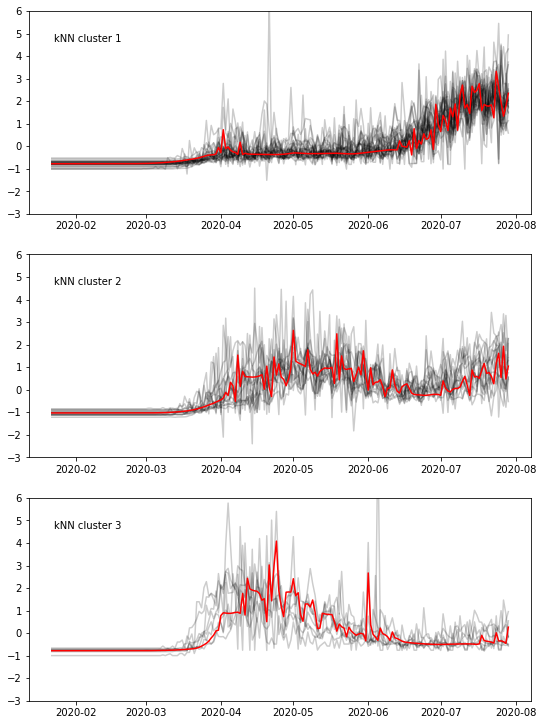

In [13]:
plot_data(scaled_data, y_p_knn, sdtw_kmeans)

## K-Shape classifier

In [14]:
def classify_scaled_data_kshape(data, n_clusters=3):
    ks = KShape(n_clusters, verbose=True, random_state=np.random.seed, n_init=16)

    y_p = ks.fit_predict(data.T)

    return {data.columns[i]: y_p[i] for i in range(len(data.columns))}, y_p, ks

In [15]:
def plot_ks(data, y_p, ks, save=True, m_factor=3):

    n_clusters = ks.n_clusters
    fig = plt.figure(figsize=(n_clusters * m_factor,
                              1.41 * n_clusters * m_factor))
    fig.tight_layout(pad=3.0)

    for yi in range(n_clusters):
        plt.subplot(n_clusters, 1, yi + 1)

        # Plot state traces
        for i in range(len(data.columns)):
            if y_p[i] == yi:
                plt.plot(data.iloc[:, i], "k-", alpha=.2)

        # Plot k-means barycenters
        c_center = pd.DataFrame(ks.cluster_centers_[yi].ravel(),
                                index=data.index)
        plt.plot(c_center, "r-")

        plt.text(0.05,
                 0.85,
                 f"K-shape cluster {yi + 1}",
                 transform=plt.gca().transAxes)
        plt.ylim(-3, 6)

    if save:
        plt.savefig("../paper/figures/ts_ks_clusters.pdf")

In [16]:
d_s_ks, y_p_ks, ks_kmeans = classify_scaled_data_kshape(scaled_data, n_clusters = 3)

Init 1
0.037 --> 0.029 --> 0.029 --> 0.029 --> 
Init 2
0.032 --> 0.031 --> 0.031 --> 
Init 3
0.035 --> 0.034 --> 0.033 --> 0.033 --> 0.033 --> 
Init 4
Resumed because of empty cluster
Init 4
0.032 --> 0.032 --> 0.032 --> 
Init 5
0.033 --> 0.027 --> 0.027 --> 0.027 --> 
Init 6
0.027 --> 0.027 --> 
Init 7
0.034 --> 0.032 --> 0.031 --> 0.032 --> 
Init 8
0.028 --> 0.026 --> 0.027 --> 
Init 9
0.042 --> 0.039 --> 0.036 --> 0.034 --> 0.033 --> 0.033 --> 0.033 --> 
Init 10
0.036 --> 0.031 --> 0.028 --> 0.028 --> 0.029 --> 
Init 11
0.057 --> 0.031 --> 0.029 --> 0.028 --> 0.028 --> 
Init 12
0.030 --> 0.028 --> 0.029 --> 
Init 13
0.034 --> 0.029 --> 0.029 --> 
Init 14
0.036 --> 0.033 --> 0.033 --> 
Init 15
0.040 --> 0.037 --> 0.035 --> 0.035 --> 0.034 --> 0.035 --> 


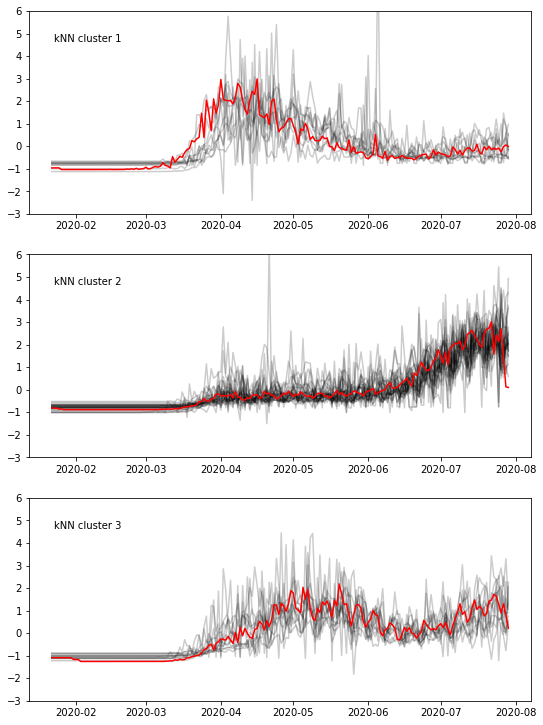

In [17]:
plot_data(scaled_data, y_p_ks, ks_kmeans)

### Create choropleth clustering map

US States shapefile extracted from [here](https://www2.census.gov/geo/tiger/GENZ2019/shp/cb_2019_us_state_5m.zip), courtesy of US Census Bureau.

In [18]:
import geopandas as gpd

In [19]:
def plot_map_with_clusters(map_df, fn="clustering", clustering_type="", save=True):
    fig, ax = plt.subplots(1, figsize=(15, 6))
    map_df.plot(column="cluster",
                cmap="viridis",
                ax=ax,
                k=4,
                legend=True,
                linewidth=10)
    ax.set_ylim(23, 52.5)
    ax.set_xlim(-127, -60)

    leg = ax.get_legend()

    for i in range(max(map_df.cluster)):
        leg.get_texts()[i].set_text(f"{clustering_type} cluster {i + 1}")

    ax.axis("off")

    if save:
        plt.savefig(f"../paper/figures/{fn}.pdf")

In [20]:
def create_cluster_map(y_p, scaled_data, fn, clustering_type):
    map_df = gpd.read_file("cb_2019_us_state_5m.shp")[["STUSPS", "geometry"]]
    map_df.index = map_df.STUSPS
    map_df = map_df[["geometry"]]

    cluster_df = pd.DataFrame([y_p, scaled_data.columns]).T
    cluster_df.columns = ["cluster", "STUSPS"]
    cluster_df.cluster = cluster_df.cluster + 1
    cluster_df.index = cluster_df.STUSPS
    cluster_df = cluster_df[["cluster"]]

    map_df = map_df.join(cluster_df)

    plot_map_with_clusters(map_df, fn, clustering_type=clustering_type)

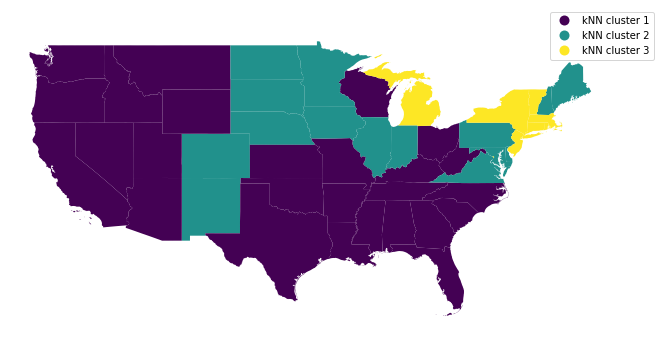

In [21]:
create_cluster_map(y_p_knn, scaled_data, fn="clustering_knn", clustering_type="kNN")

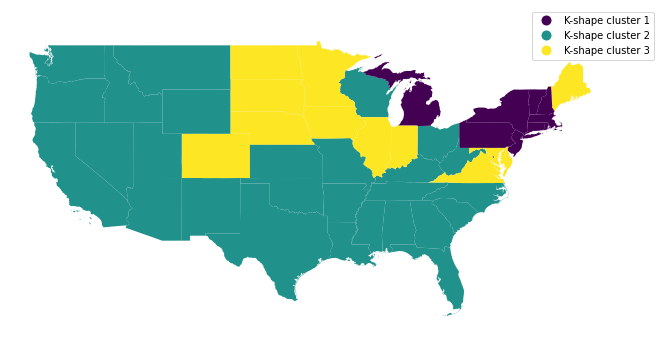

In [22]:
create_cluster_map(y_p_ks, scaled_data, fn="clustering_kshape", clustering_type="K-shape")

## Calculate Rand index between the clusterings

In [23]:
from sklearn.metrics import adjusted_rand_score

In [24]:
adjusted_rand_score(y_p_ks, y_p_knn)

0.8571792909971947